In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import requests

df = pd.read_csv('/content/drive/MyDrive/info-sec/samsung.csv')
# 날짜데이터를 Datetime 형식으로 바꿔준다
df.loc[:,'Date'] = pd.to_datetime(df.Date)
# 데이터의 정합성을 확인한다
df.isna().sum()
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)
print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 5630
삭제 후 데이터 길이(일자수): 5630


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

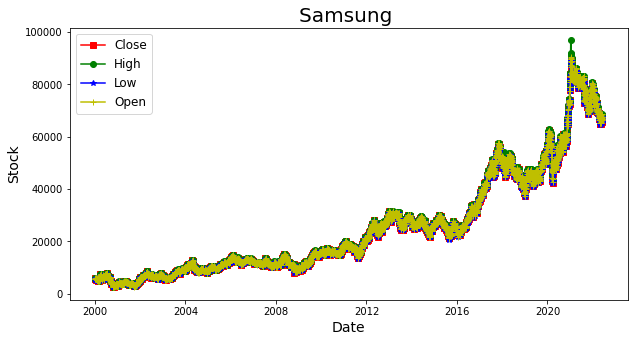

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (10,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('Samsung ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close','High','Low','Open'], fontsize=12, loc='best')
plt.show()

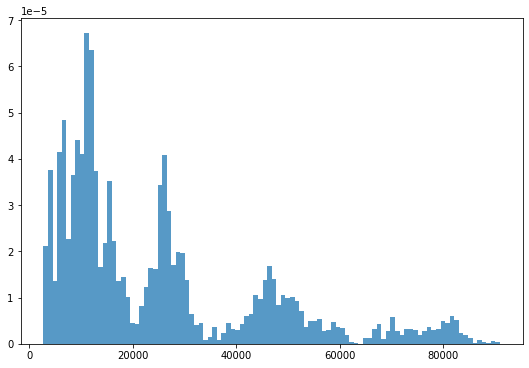

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

In [ ]:
from statsmodels.stats.weightstats import ztest

_, p = ztest(df.Close)
print(p)  # 0

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


0.0


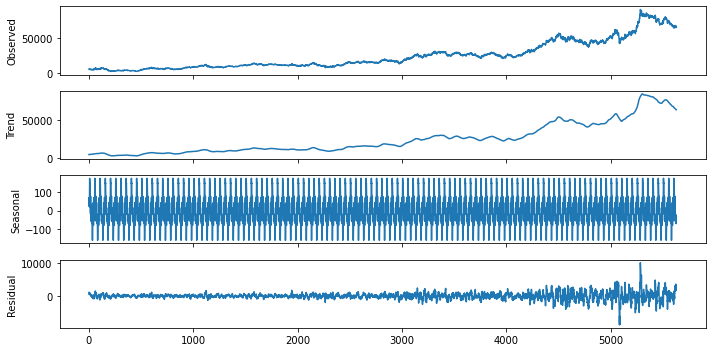

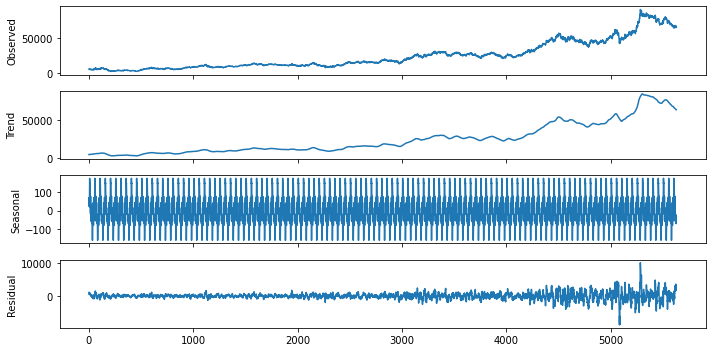

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 계절적 성분 50일로 가정
# extrapolate_trend='freq' : Trend 성분을 만들기 위한 rolling window 때문에 필연적으로 trend, resid에는 Nan 값이 발생하기 때문에, 이 NaN값을 채워주는 옵션이다.
result = seasonal_decompose(df.Close, model='additive', two_sided=True, freq=50,extrapolate_trend='freq') 
result.plot()

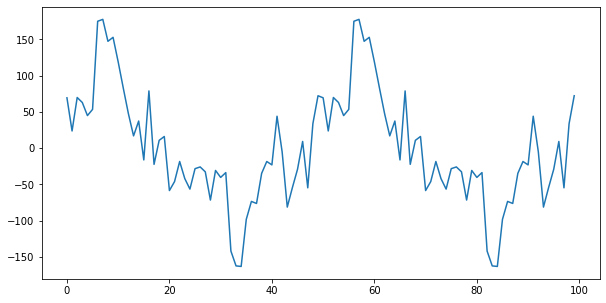

In [ ]:
result.seasonal[:100].plot()

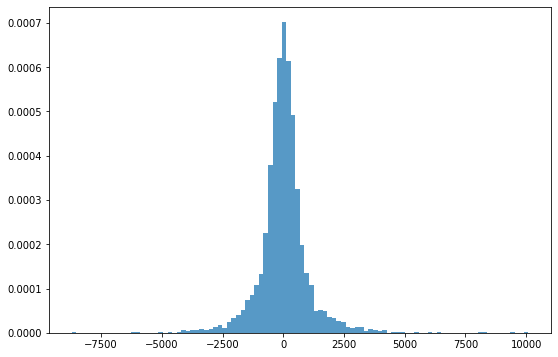

In [ ]:
# Residual의 분포 확인
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [ ]:
r = result.resid.values
st, p = ztest(r)
print(st,p) 

0.6948735022171139 0.4871345798943748


In [ ]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu)
print("표준편차:", std)


# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))


평균: 9.368886923797055
표준편차: 1011.6643445235127
이상치 갯수: 112


In [ ]:
df.Date[result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

4385   2017-05-08
4436   2017-07-20
4452   2017-08-11
4453   2017-08-14
4467   2017-09-04
          ...    
5619   2022-05-20
5620   2022-05-23
5625   2022-05-30
5626   2022-05-31
5628   2022-06-03
Name: Date, Length: 112, dtype: datetime64[ns]

In [ ]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose를 수행한다.
    for f in features:
        result = seasonal_decompose(df[f], model='additive', freq=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5630.000000,5630.000000,5630.000000,5630.000000,5.630000e+03
mean,24941.245372,25192.520090,24684.829833,24936.691917,2.176571e+07
std,20094.627463,20260.306456,19923.735708,20080.823201,1.073318e+07
min,3242.600000,3340.500000,3163.400000,3259.800000,8.825045e+06
25%,10115.550000,10235.425000,10000.825000,10120.200000,1.314502e+07
50%,16334.000000,16487.900000,16148.600000,16319.300000,1.955083e+07
75%,31766.400000,32204.550000,31492.500000,31886.200000,2.651233e+07
max,84383.000000,85608.000000,83416.000000,84313.000000,7.266760e+07


In [ ]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5630.000000,5630.000000,5630.000000,5630.000000,5.630000e+03
mean,9.989998,9.913577,9.124072,9.475762,-1.161156e+04
std,1014.984687,1006.942021,987.663985,1011.846068,1.094251e+07
min,-8662.822502,-8498.147137,-8540.440213,-8711.474238,-7.010217e+07
25%,-401.634798,-405.090104,-393.416798,-413.309667,-4.520781e+06
50%,4.068115,0.349143,2.476763,5.517805,-1.161546e+06
75%,411.462845,392.271675,402.196253,408.949738,3.439689e+06
max,9360.295356,14609.324292,9718.559787,10083.441833,9.549285e+07


In [ ]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
# [-0.40184982  -0.38035856  -0.39874878  -0.37402025 -195.40645742]

norm_rdf = scaler.transform(rdf)
norm_rdf

[ 9.98999848e+00  9.91357726e+00  9.12407232e+00  9.47576165e+00
 -1.16115582e+04]


array([[ 0.91049378,  0.94485457,  0.76319233,  1.06571492,  2.06343412],
       [ 0.73231584,  0.91140349,  0.62369328,  0.56867739,  1.93682018],
       [ 0.66407391,  0.5997526 ,  0.64622584,  0.54419678, -0.03804234],
       ...,
       [ 2.80963702,  2.6765217 ,  2.93000737,  2.82886965, -0.09875707],
       [ 3.59222865,  3.16722954,  3.50891551,  3.09579198, -0.82225883],
       [ 2.75976516,  2.3669442 ,  2.24740122,  1.90013435,  0.28431761]])

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인
# [1 1 1 ... 0 0 0]


# 라벨은 몇번 그룹인지 뜻한다. 
# return_counts=True : 몇개의 샘플이 몇번 그룹에 할당되었는지 확인
lbl, cnt = np.unique(kmeans.labels_,return_counts=True) 
print(lbl) # [0 1]  -> 0번 그룹, 1번 그룹으로 나뉨
print(cnt) # [3258 2434]  -> 0번그룹에 3258, 1번그룹에 2434

[0 0 0 ... 0 0 0]
[0 1]
[2623 3007]


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]


['group:0-count:454',
 'group:1-count:191',
 'group:2-count:460',
 'group:3-count:102',
 'group:4-count:158',
 'group:5-count:695',
 'group:6-count:539',
 'group:7-count:113',
 'group:8-count:805',
 'group:9-count:127',
 'group:10-count:6',
 'group:11-count:258',
 'group:12-count:837',
 'group:13-count:37',
 'group:14-count:40',
 'group:15-count:246',
 'group:16-count:4',
 'group:17-count:162',
 'group:18-count:41',
 'group:19-count:355']

In [ ]:
df[(kmeans.labels_==10)]

,Date,Open,High,Low,Close,Adj Close,Volume
5284,2021-01-08,83300.0,90000.0,83000.0,88800.0,86758.750000,59013307
5285,2021-01-11,90000.0,96800.0,89500.0,91000.0,88908.179688,90306177
5286,2021-01-12,90300.0,91400.0,87800.0,90600.0,88517.367188,48682416
5287,2021-01-13,89800.0,91200.0,89100.0,89700.0,87638.062500,36068848
5288,2021-01-14,88700.0,90000.0,88700.0,89700.0,87638.062500,26393970
5289,2021-01-15,89800.0,91800.0,88000.0,88000.0,85977.132813,33431809


In [ ]:
df[(kmeans.labels_==13)]

,Date,Open,High,Low,Close,Adj Close,Volume
22,2000-02-03,5250.0,5460.0,4970.0,5130.0,3905.631836,142765000
33,2000-02-18,5370.0,5630.0,5160.0,5300.0,4035.059082,108750000
42,2000-03-02,5880.0,5880.0,5520.0,5880.0,4476.632813,117750000
43,2000-03-03,6200.0,6250.0,5880.0,6000.0,4567.991211,140990000
58,2000-03-24,6320.0,7120.0,6180.0,6800.0,5177.056641,90260000
172,2000-08-31,5900.0,5900.0,5380.0,5470.0,4164.485840,114120000
182,2000-09-14,4600.0,4710.0,4440.0,4710.0,3585.874268,106130000
184,2000-09-18,4010.0,4120.0,3700.0,3970.0,3022.488037,146305000
206,2000-10-18,2540.0,2760.0,2420.0,2730.0,2078.436768,164215000
207,2000-10-19,2730.0,3050.0,2690.0,2900.0,2207.862549,137720000


In [ ]:
df[(kmeans.labels_==14)]

,Date,Open,High,Low,Close,Adj Close,Volume
4452,2017-08-11,45120.0,45300.0,44220.0,44620.0,38765.277344,25407300
4453,2017-08-14,45120.0,45400.0,44720.0,45000.0,39095.410156,19185600
4463,2017-08-29,45640.0,46080.0,45160.0,46080.0,40033.699219,12623650
4467,2017-09-04,45780.0,46360.0,45500.0,46040.0,39998.949219,7943500
4570,2018-02-09,44440.0,45180.0,44420.0,44700.0,39290.781250,17465000
4571,2018-02-12,45100.0,46320.0,45040.0,45720.0,40187.351563,15754950
4787,2019-01-03,38300.0,38550.0,37450.0,37600.0,34106.777344,12471493
4788,2019-01-04,37450.0,37600.0,36850.0,37450.0,33970.714844,14108958
4789,2019-01-07,38000.0,38900.0,37800.0,38750.0,35149.933594,12748997
4790,2019-01-08,38000.0,39200.0,37950.0,38100.0,34560.328125,12756554


In [ ]:
df[(kmeans.labels_==16)]

,Date,Open,High,Low,Close,Adj Close,Volume
5085,2020-03-19,46400.0,46650.0,42300.0,42950.0,40115.921875,56925513
5086,2020-03-20,44150.0,45500.0,43550.0,45400.0,42404.250000,49730008
5087,2020-03-23,42600.0,43550.0,42400.0,42500.0,39695.613281,41701626
5088,2020-03-24,43850.0,46950.0,43050.0,46950.0,43851.972656,49801908


In [ ]:
df[(kmeans.labels_==18)]

,Date,Open,High,Low,Close,Adj Close,Volume
5043,2020-01-17,61900.0,62000.0,61000.0,61300.0,57255.085938,16025661
5044,2020-01-20,62000.0,62800.0,61700.0,62400.0,58282.500000,12528855
5045,2020-01-21,62000.0,62400.0,61200.0,61400.0,57348.480469,11142693
5060,2020-02-13,61200.0,61600.0,60500.0,60700.0,56694.675781,18449775
5061,2020-02-14,60900.0,61900.0,60200.0,61800.0,57722.089844,13276067
5062,2020-02-17,61600.0,62000.0,61200.0,61500.0,57441.886719,8740596
5063,2020-02-18,60800.0,60900.0,59700.0,59800.0,55854.062500,16674266
5064,2020-02-19,59800.0,60400.0,59400.0,60200.0,56227.671875,12951496
5065,2020-02-20,60700.0,61300.0,59600.0,60000.0,56040.859375,14591924
5075,2020-03-05,57600.0,58000.0,56700.0,57800.0,53986.027344,21698990


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5630.000000,5630.000000,5630.000000,5630.000000,5630.000000,5.630000e+03
mean,24951.412078,25202.568384,24694.158082,24946.333925,21801.150360,2.175329e+07
std,20162.228775,20327.518180,19988.082163,20147.118780,19805.794138,1.544223e+07
min,2540.000000,2760.000000,2420.000000,2730.000000,2078.436768,0.000000e+00
25%,10180.000000,10320.000000,10020.000000,10180.000000,7796.392456,1.179831e+07
50%,16610.000000,16850.000000,16450.000000,16630.000000,13318.129883,1.771785e+07
75%,31420.000000,31760.000000,31135.000000,31410.000000,26677.304688,2.721115e+07
max,90300.000000,96800.000000,89500.000000,91000.000000,88908.179688,1.642150e+08


In [ ]:
# 각 그룹의 중심부는 어떤 값을 가지고 있는지 확인
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

,Open,High,Low,Close,Volume
0,0.113320,0.075792,0.142128,0.105955,-0.980648
1,1.611439,1.653100,1.582005,1.600511,0.112079
2,-0.240879,-0.197110,-0.299479,-0.242530,0.707176
3,-2.377536,-2.354095,-2.483290,-2.393466,0.266523
4,-0.208519,-0.175775,-0.305804,-0.270094,2.398616
5,0.468611,0.456151,0.508310,0.481211,-0.249825
6,-0.703054,-0.736303,-0.687228,-0.712687,-0.175120
7,2.450143,2.432175,2.531568,2.470686,-0.059748
8,-0.270370,-0.294390,-0.244770,-0.258737,-0.328560
9,-0.063807,-0.161129,0.030840,-0.067136,-3.096439


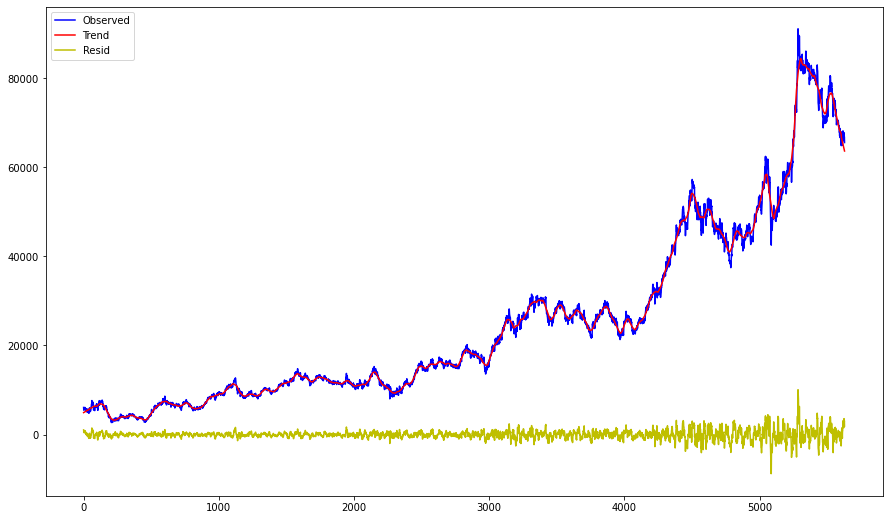

In [ ]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True, color='b')
tdf.Close.plot(ax=ax, label='Trend', legend=True, color='r')
rdf.Close.plot(ax=ax,label='Resid', legend=True, color='y')
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
print(clustering)  # BSCAN(eps=0.7, min_samples=2)
print(clustering.labels_)  # [0 0 0 ... 0 0 0]

lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

DBSCAN(eps=0.7, min_samples=2)
[0 0 0 ... 0 0 0]


['group:-1-count:94',
 'group:0-count:5514',
 'group:1-count:4',
 'group:2-count:2',
 'group:3-count:2',
 'group:4-count:2',
 'group:5-count:2',
 'group:6-count:6',
 'group:7-count:2',
 'group:8-count:2']

(32, 10, 4)
(32, 4)
Epoch 1/50
176/176 [==============================] - ETA: 0s - loss: 1.9690 - mae: 1.9690
Epoch 1: val_loss improved from inf to 3.81659, saving model to /root/aiffel/anomaly_detection/kospi/mymodel.ckpt
176/176 [==============================] - 11s 31ms/step - loss: 1.9690 - mae: 1.9690 - val_loss: 3.8166 - val_mae: 3.8166
Epoch 2/50
175/176 [============================>.] - ETA: 0s - loss: 0.6135 - mae: 0.6135
Epoch 2: val_loss improved from 3.81659 to 0.38942, saving model to /root/aiffel/anomaly_detection/kospi/mymodel.ckpt
176/176 [==============================] - 5s 28ms/step - loss: 0.6106 - mae: 0.6106 - val_loss: 0.3894 - val_mae: 0.3894
Epoch 3/50
175/176 [============================>.] - ETA: 0s - loss: 0.2875 - mae: 0.2875
Epoch 3: val_loss did not improve from 0.38942
176/176 [==============================] - 5s 28ms/step - loss: 0.3005 - mae: 0.3005 - val_loss: 0.7541 - val_mae: 0.7541
Epoch 4/50
176/176 [==============================] - ETA: 0s

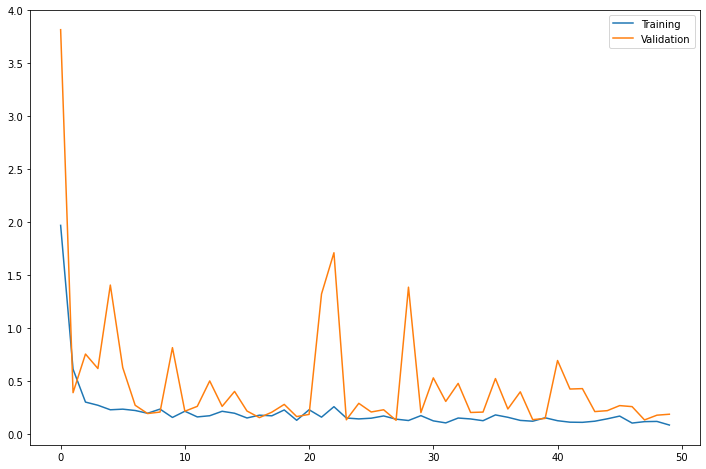

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler


# 모델 재현성을 위해 난수 시드설정
tf.random.set_seed(777)
np.random.seed(777)

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리 - 표준정규분포화
scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

# keras TimeseriesGenerator를 이용해 데이터셋 만들기
train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)  # (32, 10, 5)
print(train_gen[0][1].shape)  # (32, 5)


# 모델만들기
# 2개 층의 LSTM으로 인코더 만듬
# RepeatVector는 input을 window_size만큼 복사해줌
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])


# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다
early_stop = EarlyStopping(monitor='val_loss', patience=50)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])


hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])
          

model.load_weights(checkpoint_path)
# <tensorflow.python.training.tracking.util.CheckpointLoadStatus at 0x7fa7e4312910>
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

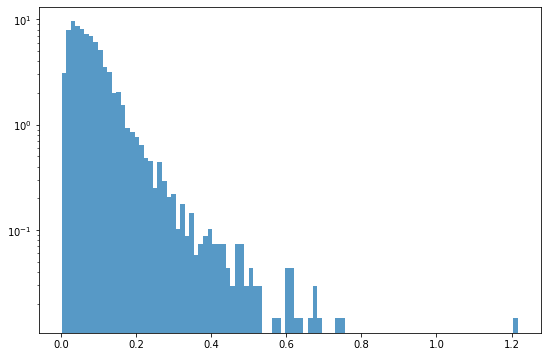

In [ ]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [ ]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 0.3
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
3150,2012-05-18,24080.0,24100.0,23300.0,23320.0,18893.855469,30023750,0.322008
3218,2012-08-27,23780.0,24060.0,23460.0,23600.0,19128.908203,63803450,0.310470
4216,2016-09-12,29800.0,30120.0,29120.0,29300.0,24909.025391,26499350,0.411415
4234,2016-10-12,29900.0,30900.0,29880.0,30700.0,26099.216797,39088550,0.355344
4372,2017-04-28,45780.0,45800.0,44520.0,44620.0,38651.500000,22685700,0.349746
...,...,...,...,...,...,...,...,...
5587,2022-04-18,66500.0,67100.0,66100.0,66700.0,66700.000000,10119203,0.322407
5594,2022-04-27,65400.0,65500.0,64900.0,65000.0,65000.000000,18122084,0.381478
5595,2022-04-28,65400.0,65500.0,64500.0,64800.0,64800.000000,16895527,0.334691
5603,2022-05-12,65200.0,65500.0,64900.0,64900.0,64900.000000,16414188,0.303574


In [ ]:
# threashold = 1
# test_df.loc[test_df.Loss>threshold]

/usr/local/lib/python3.7/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


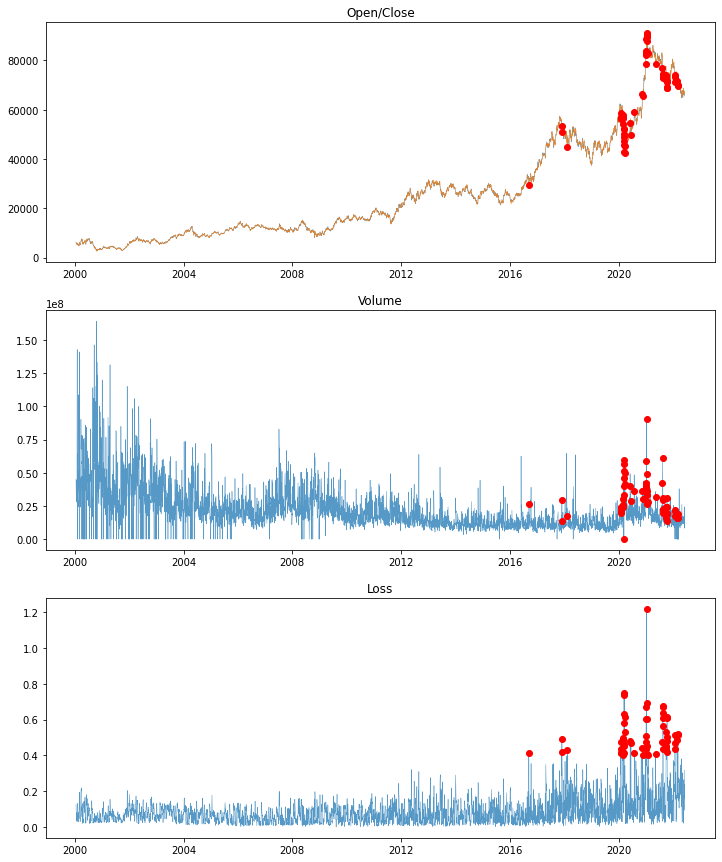

In [ ]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])